In [1]:
import os
from pyspark.sql import SparkSession
import os
from pyspark.sql import SparkSession


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.5.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0 pyspark-shell'


In [3]:
spark = (
    SparkSession
    .builder
    .appName("Project App")
    .config('spark.sql.shuffle.partitions', 4)
    .config('sspark.default.parallelism', 4)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
spark


23/10/27 13:03:26 WARN Utils: Your hostname, mac.local resolves to a loopback address: 127.0.0.1; using 10.0.0.39 instead (on interface en0)
23/10/27 13:03:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/anaconda3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hims/.ivy2/cache
The jars for the packages stored in: /Users/hims/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bc6bbb79-762c-4233-87a3-2cfbe536dab3;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.spark#spark-sql-kafka-0-10_

### Business Data
```
{
    "business_id": "Pns2l4eNsfO8kk83dixA6A",
    "name": "Abby Rappoport, LAC, CMQ",
    "address": "1616 Chapala St, Ste 2",
    "city": "Santa Barbara",
    "state": "CA",
    "postal_code": "93101",
    "latitude": 34.4266787,
    "longitude": -119.7111968,
    "stars": 5.0,
    "review_count": 7,
    "is_open": 0,
    "attributes": {
        "ByAppointmentOnly": "True"
    },
    "categories": "Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",
    "hours": null
}
```

In [4]:
! head -1 ~/Downloads/yelp_dataset/yelp_academic_dataset_business.json | python -m json.tool

{
    "business_id": "Pns2l4eNsfO8kk83dixA6A",
    "name": "Abby Rappoport, LAC, CMQ",
    "address": "1616 Chapala St, Ste 2",
    "city": "Santa Barbara",
    "state": "CA",
    "postal_code": "93101",
    "latitude": 34.4266787,
    "longitude": -119.7111968,
    "stars": 5.0,
    "review_count": 7,
    "is_open": 0,
    "attributes": {
        "ByAppointmentOnly": "True"
    },
    "categories": "Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",
    "hours": null
}


In [119]:
businessDf = (
    spark
    .read
    .format("json")
    .load('/Users/hims/Downloads/yelp_dataset/yelp_academic_dataset_business.json')
)
businessDf.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [120]:
from pyspark.sql.functions import from_json, col, map_keys
from pyspark.sql.functions import split

businessDf.select("categories").printSchema()

print("After schema change - \n")
businessDf = businessDf.withColumn("categories", split(col("categories"), ", "))
businessDf.select("categories").printSchema()

root
 |-- categories: string (nullable = true)

After shcema change - 

root
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = false)


In [113]:
# Convert struct field 'attributes' to MapType
cols = businessDf.select("attributes.*").columns
businessDf.select("attributes").printSchema()


print("after transformation - ")
df_with_map = businessDf.selectExpr("map(" + ", ".join(["attributes."+col for col in cols[:-1]]) + ") as attributes")
df_with_map.printSchema()


root
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: string (nullable = true)
 |    |-- GoodFor

In [53]:
businessDf.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|[Doctors, Traditi...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|[Shipping Centers...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

### Users Data

```
{
    "user_id": "wL5jPrLRVCK_Pmo4lM1zpA",
    "name": "Isa",
    "review_count": 2,
    "yelping_since": "2020-12-19 02:32:39",
    "useful": 0,
    "funny": 0,
    "cool": 0,
    "elite": "",
    "friends": "None",
    "fans": 0,
    "average_stars": 5.0,
    "compliment_hot": 0,
    "compliment_more": 0,
    "compliment_profile": 0,
    "compliment_cute": 0,
    "compliment_list": 0,
    "compliment_note": 0,
    "compliment_plain": 0,
    "compliment_cool": 0,
    "compliment_funny": 0,
    "compliment_writer": 0,
    "compliment_photos": 0
}
```


In [8]:
userDf = (
    spark
    .read
    .format("json")
    .load('/Users/hims/Downloads/yelp_dataset/yelp_academic_dataset_user.json')
)

userDf.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)


In [9]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.functions import split

userDf = userDf.withColumn("friends", split(col("friends"), ", "))
userDf.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)


In [10]:
userDf.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|    

In [135]:
from pyspark.sql.functions import size

userDf.filter(size(col("friends")) == 1).select("friends").show(100, False)

+------------------------+
|friends                 |
+------------------------+
|[N7gCuIKUlHL7HwySHZ4YYQ]|
|[g9ipc9giAo_JVhACQP5qEg]|
|[PhuWAInYFJ_vysRfrV_m1g]|
|[XAlgPQYihaK-r3ZsKNYVcg]|
|[qvOSR1h7rS_h-4aLI0hDAA]|
|[y8aWXOimQ9ZgUgZ6q--nCQ]|
|[4LQ0ksZp2tW0kLiJ8SVSXg]|
|[z3XpmV1CD_z_qDxGQYw9CA]|
|[BkxX9p65_dM0XuJYO5DHig]|
|[ny_BZK1G_RjCe2--82_RhQ]|
|[iQe9QOnG-LPsZu1ErRio2Q]|
|[uKZaU4nnY9EI8Ir7BSA5nA]|
|[qeatFnEGJTaloJinL1M5HQ]|
|[OgAo_70JmIurevC14uTBiA]|
|[U0yw8KQeXwMib5c29ibg8g]|
|[CHS8iOs0xGZPS5lfBe-khQ]|
|[1bKnS0zLO63Bee_hKfIZhA]|
|[6Mv-qMJyxSokCu8YFM1o0A]|
|[gIyrUDqGTfb25xOm95pEvw]|
|[kaHmTcEoVS3oQvfJfDe8kg]|
|[YnMj40BqosIRHNTuHFd_Yw]|
|[H48HEiv-5zEYpMoWwhpdtA]|
|[k1rm_oKCAmaGjQ07gQuqig]|
|[90QrD73MiLPjs4mtkmBqQQ]|
|[5sc5sYfuiliqty9_d-NZRA]|
|[GPq34B_u8phlLQb8qd710Q]|
|[e4nLpR0I_0tn0noOH2-juw]|
|[JKn4JKyU5CfjRma9kCEHfQ]|
|[yXCOquX-wufuyscCIJlmjQ]|
|[koEZM3h_Kli6NJ2w8OrJfw]|
|[ARTcWZsBG6AzevV2zcrKlA]|
|[IavKWkwDCAx_5EwX5xuOgQ]|
|[Aooz3c9LezL8G5Rmf2HaWg]|
|[TaymD7MKm8OH1VI77kMWMw]|
|

### Checkin Data

```
{
    "business_id": "---kPU91CF4Lq2-WlRu9Lw",
    "date": "2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020-07-24 22:42:27, 2020-10-24 21:36:13, 2020-12-09 21:23:33, 2021-01-20 17:34:57, 2021-04-30 21:02:03, 2021-05-25 21:16:54, 2021-08-06 21:08:08, 2021-10-02 15:15:42, 2021-11-11 16:23:50"
}```

In [11]:
checkinDf = (
    spark
    .read
    .format("json")
    .load('/Users/hims/Downloads/yelp_dataset/yelp_academic_dataset_checkin.json')
)

checkinDf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)


In [12]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.functions import split

checkinDf = checkinDf.withColumn("date", split(col("date"), ", "))
checkinDf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: array (nullable = true)
 |    |-- element: string (containsNull = false)


In [13]:
checkinDf.show(5)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|[2020-03-13 21:10...|
|--0iUa4sNDFiZFrAd...|[2010-09-13 21:43...|
|--30_8IhuyMHbSOcN...|[2013-06-14 23:29...|
|--7PUidqRWpRSpXeb...|[2011-02-15 17:12...|
|--7jw19RH9JKXgFoh...|[2014-04-21 20:42...|
+--------------------+--------------------+


In [14]:
checkinDf.count()

131930

### Tip Data

```
{
    "user_id": "AGNUgVwnZUey3gcPCJ76iw",
    "business_id": "3uLgwr0qeCNMjKenHJwPGQ",
    "text": "Avengers time with the ladies.",
    "date": "2012-05-18 02:17:21",
    "compliment_count": 0
}
```

In [15]:
tipDf = (
    spark
    .read
    .format("json")
    .load('/Users/hims/Downloads/yelp_dataset/yelp_academic_dataset_tip.json')
)

tipDf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)


In [16]:
tipDf.show(5)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|ld0AperBXk1h6Ubqm...|
+--------------------+----------------+-------------------+--------------------+--------------------+


### Review Data

```
{
    "review_id": "KU_O5udG6zpxOg-VcAEodg",
    "user_id": "mh_-eMZ6K5RLWhZyISBhwA",
    "business_id": "XQfwVwDr-v0ZS3_CbbE5Xw",
    "stars": 3.0,
    "useful": 0,
    "funny": 0,
    "cool": 0,
    "text": "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
    "date": "2018-07-07 22:09:11"
}
````

In [17]:
reviewDf = (
    spark
    .read
    .format("json")
    .load('/Users/hims/Downloads/yelp_dataset/yelp_academic_dataset_review.json')
)

reviewDf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)


In [18]:
reviewDf.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

### Stats for the datasets

In [19]:
print(f" {userDf.count() = }")
print(f" {businessDf.count() = }")
print(f" {checkinDf.count() = }")
print(f" {tipDf.count() = }")
print(f" {reviewDf.count() = }")

 userDf.count() = 1987897
 businessDf.count() = 150346
 checkinDf.count() = 131930
 tipDf.count() = 908915


 reviewDf.count() = 6990280


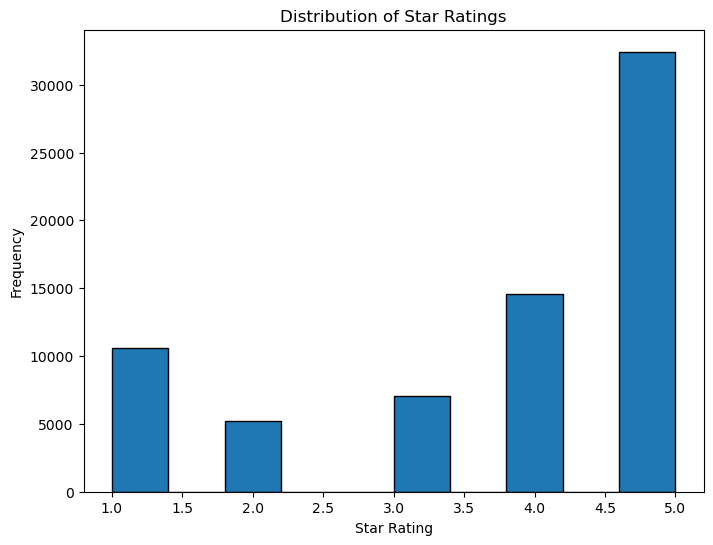

In [23]:
# Histogram of star ratings
import seaborn as sns
# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode

df = reviewDf.select("stars").sample(False, 0.01).toPandas()
plt.figure(figsize=(8, 6))
plt.hist(df['stars'], bins=10, edgecolor='black')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings')
plt.show()

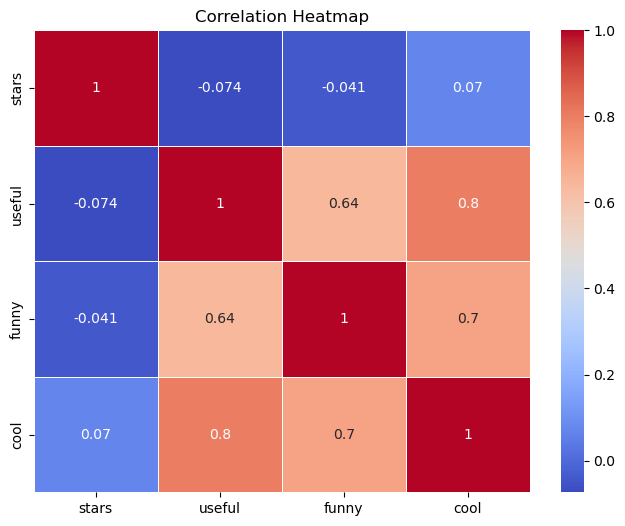

In [136]:
df = reviewDf.select('stars', 'useful', 'funny', 'cool').sample(False, .01).toPandas()
correlation_matrix = df[['stars', 'useful', 'funny', 'cool']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

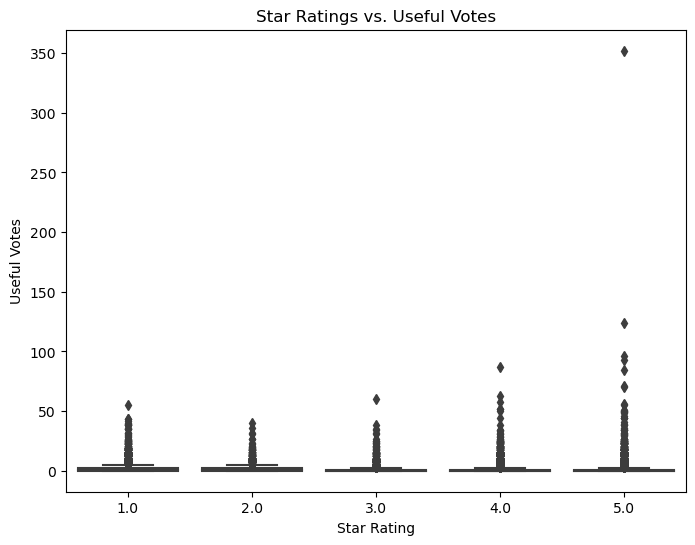

In [24]:
df = reviewDf.select('stars', 'useful').sample(False, .01).toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(x='stars', y='useful', data=df)
plt.xlabel('Star Rating')
plt.ylabel('Useful Votes')
plt.title('Star Ratings vs. Useful Votes')
plt.show()

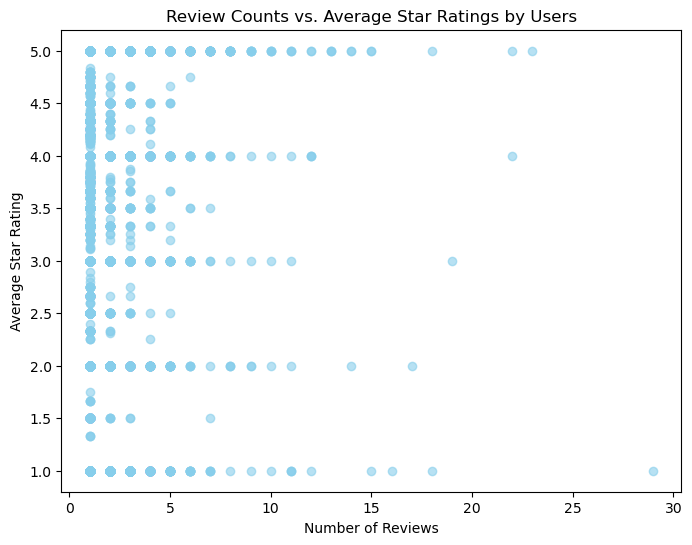

In [25]:
df = reviewDf.select("user_id", "stars").sample(False, .01).toPandas()
user_review_counts = df['user_id'].value_counts()
average_stars_by_user = df.groupby('user_id')['stars'].mean()

plt.figure(figsize=(8, 6))
plt.scatter(user_review_counts, average_stars_by_user, color='skyblue', alpha=0.6)
plt.xlabel('Number of Reviews')
plt.ylabel('Average Star Rating')
plt.title('Review Counts vs. Average Star Ratings by Users')
plt.show()

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df =  userDf.select("user_id", "friends").select("user_id", explode("friends").alias("friend")) \
    .groupBy("user_id").count().withColumnRenamed("count", "number_of_friends") \
    .groupBy("number_of_friends").count().withColumnRenamed("count", "number_of_users") \
    .orderBy(col("number_of_friends").asc()) \
    .toPandas()

pandas_df.head(10)




,number_of_friends,number_of_users
0,1,993654
1,2,57923
2,3,38827
3,4,30168
4,5,24389
5,6,20785
6,7,18323
7,8,16492
8,9,14954
9,10,13579


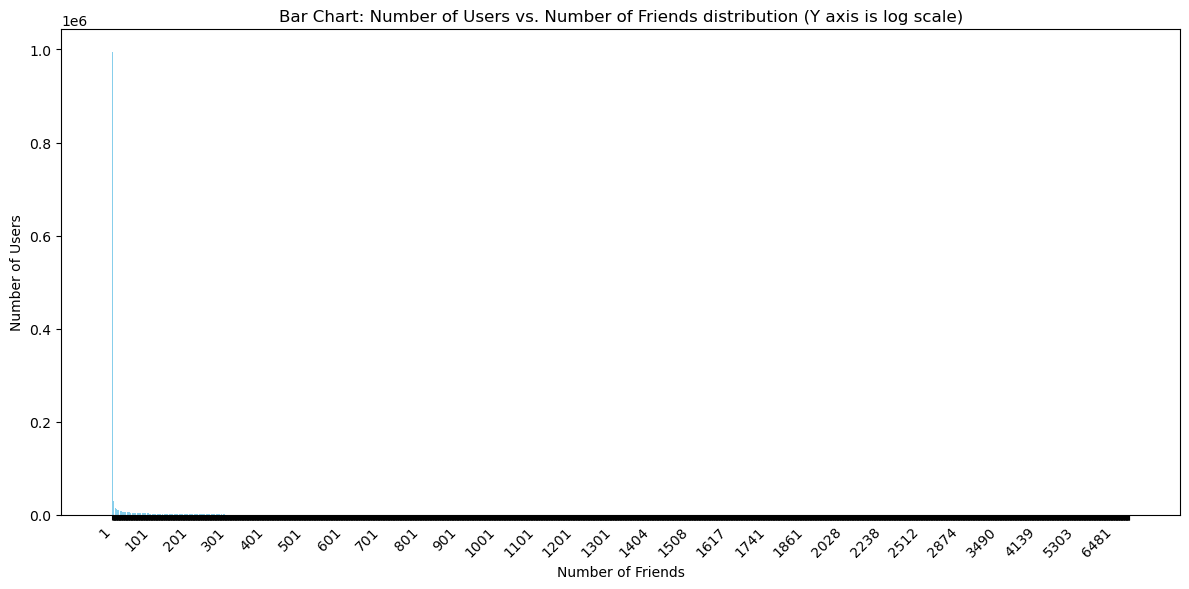

In [127]:
# Categories (for x-axis labels)
df = pandas_df
categories = [str(x) for x in df['number_of_friends']]

# Create a bar chart
plt.figure(figsize=(12, 6))
# plt.yscale('log')  # Set y-axis to logarithmic scale
plt.bar(categories, df['number_of_users'], color='skyblue')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.title('Bar Chart: Number of Users vs. Number of Friends distribution (Y axis is log scale)')
plt.xticks(df.index, [label if index%100 == 0 else '' for index, label in enumerate(df['number_of_friends'])])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
# Define bin edges with step size 100
bins = list(range(1, max(df['number_of_friends']) + 101, 100))

# Bin the 'number_of_friends' column into 100-size buckets and sum 'number_of_users' for each bucket
df['buckets'] = pd.cut(df['number_of_friends'], bins=bins, right=False)
result = df.groupby('buckets')['number_of_users'].sum().reset_index()
result.head()


categories = [str(x) for x in df['buckets']]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, df['number_of_users'], color='skyblue')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.title('Bar Chart: Number of Users vs. Number of Friends')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()



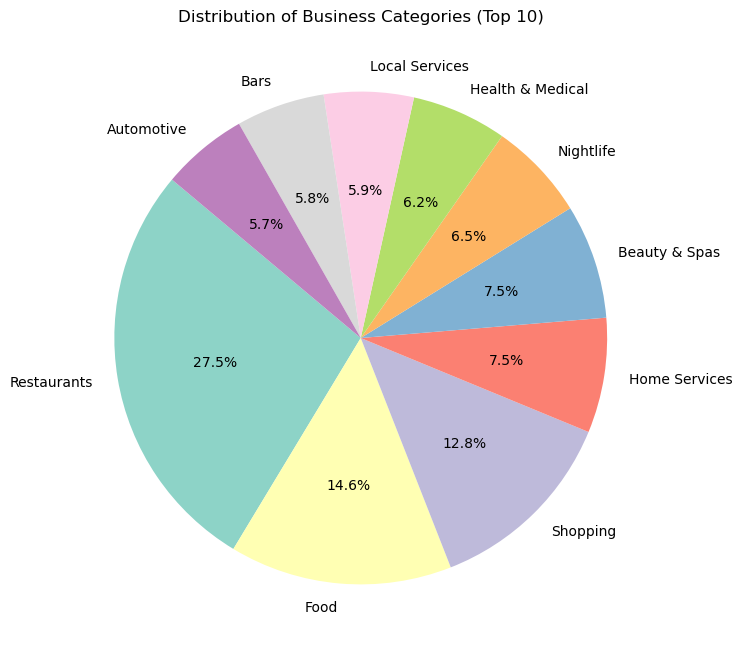

In [56]:
from pyspark.sql.functions import explode

business_df = businessDf.select("categories").toPandas()
category_counts = business_df['categories'].explode().value_counts().head(10)
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Distribution of Business Categories (Top 10)')
plt.show()

In [79]:
# Sample data with a struct field
from pyspark.sql.functions import expr

data = [("Alice", ("apple", 10)), ("Bob", ("orange", 15)), ("Charlie", ("banana", 20))]
schema = ["name", "struct_field"]

# Create DataFrame
df = spark.createDataFrame(data, schema)
df.printSchema()
# Convert struct field to map type
df_with_map = df.withColumn("map_field", expr("map(struct_field.*)"))
df_with_map.printSchema()

root
 |-- name: string (nullable = true)
 |-- struct_field: struct (nullable = true)
 |    |-- _1: string (nullable = true)
 |    |-- _2: long (nullable = true)

root
 |-- name: string (nullable = true)
 |-- struct_field: struct (nullable = true)
 |    |-- _1: string (nullable = true)
 |    |-- _2: long (nullable = true)
 |-- map_field: map (nullable = false)
 |    |-- key: string
 |    |-- value: long (valueContainsNull = true)
